# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [132]:
import datetime
import pickle
import matplotlib.pyplot as plt


In [133]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

In [134]:
# explore the offers
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [140]:
def wrangle_portfolio(portfolio):
    '''
    Clean and wrangle the portfolio dataframe
    
    INPUT:
    portfolio - the dataframe to be cleaned and wrangled
    
    OUTPUT:
    portfolio - the cleaned and wrangled portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    
    
    # Encoding for channel
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    
    cleaned_portfolio.drop('channels', 1, inplace=True)
    
    return cleaned_portfolio

In [141]:
cleaned_portfolio = wrangle_portfolio(portfolio)

In [142]:
cleaned_portfolio

reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   
5       3           7         7       discount   
6       2          10        10       discount   
7       0           0         3  informational   
8       5           5         5           bogo   
9       2          10         7       discount   

                                 id  web  email  mobile  social  
0  ae264e3637204a6fb9bb56bc8210ddfd    0      1       1       1  
1  4d5c57ea9a6940dd891ad53e9dbe8da0    1      1       1       1  
2  3f207df678b143eea3cee63160fa8bed    1      1       1       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9    1      1       1       0  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7    1      1       0       0  
5  2298d6c36e964ae4a3e7e9706d1fb8c2    1      1       1       1  
6  fafdcd668e3743c1bb461111dcafc2a4    1      1       1       1  
7  5a8bc65990b245e5a138643cd4eb9837    0      1       1       1  
8  f19421c1d4aa40978ebb69ca19b0e20d    1      1       1       1  
9  2906b810c7d4411798c6938adc9daaa5    1      1       1       0

In [143]:
# explore the users
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [144]:
# There are 118 for age which could be when not available and income and gender has nulls too
profile.loc[profile['gender'].isnull()].describe()

age  became_member_on  income
count  2175.0      2.175000e+03     0.0
mean    118.0      2.016804e+07     NaN
std       0.0      1.009105e+04     NaN
min     118.0      2.013080e+07     NaN
25%     118.0      2.016070e+07     NaN
50%     118.0      2.017073e+07     NaN
75%     118.0      2.017123e+07     NaN
max     118.0      2.018073e+07     NaN

In [145]:
# We need to drop these records with no values . Before the drop the shape is 
profile.shape

(17000, 5)

In [146]:
# Are there duplcate users

profile.duplicated(['id']).sum()

0

In [147]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    
    
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    
    # To transform the feature, we create a new column
    profile['member_on'] = pd.to_datetime(profile['became_member_on'].astype(str)).dt.date
    profile.drop('became_member_on', 1, inplace=True)
    
      
    
    return profile


In [148]:
cleaned_profile = clean_profile(profile)

In [149]:
cleaned_profile.head()

gender   age                                id    income   member_on
1       F  55.0  0610b486422d4921ae7d2bf64640c50b  112000.0  2017-07-15
3       F  75.0  78afa995795e4d85b5d9ceeca43f5fef  100000.0  2017-05-09
5       M  68.0  e2127556f4f64592b11af22de27a7932   70000.0  2018-04-26
8       M  65.0  389bc3fa690240e798340f5a15918d5c   53000.0  2018-02-09
12      M  58.0  2eeac8d8feae4a8cad5a6af0499a211d   51000.0  2017-11-11

In [150]:
cleaned_profile.describe()

age         income
count  14825.000000   14825.000000
mean      54.393524   65404.991568
std       17.383705   21598.299410
min       18.000000   30000.000000
25%       42.000000   49000.000000
50%       55.000000   64000.000000
75%       66.000000   80000.000000
max      101.000000  120000.000000

In [151]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    user_gender = cleaned_profile.gender.value_counts().plot(kind='bar', title='Gender')
    user_gender.set_xlabel("Customer Gender")
    plt.figure()
    
    # Display Histogram of Customer Age
    user_age = cleaned_profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
    user_age.set_xlabel("Customer Age")
    plt.figure()
     
    # Display Histogram of User Income
    user_income = cleaned_profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
    user_income.set_xlabel("Income")
    plt.figure()
        
     # Display Histogram of the membership join date
    
    user_join_dt = cleaned_profile['member_on'].hist()
    user_join_dt.set_xlabel("Membership Start Date")
    plt.title('Membersip Start Date')
    plt.figure()
    
    


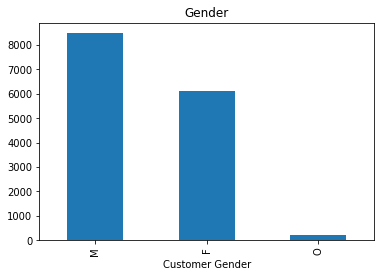

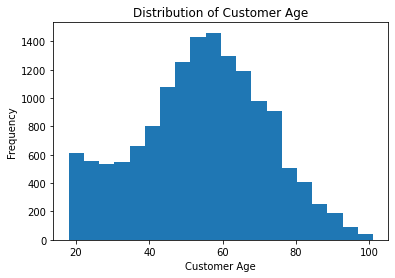

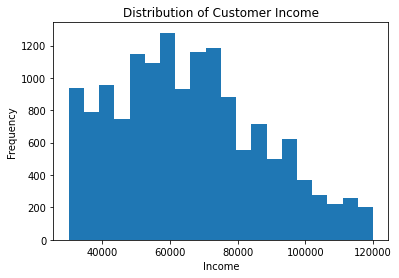

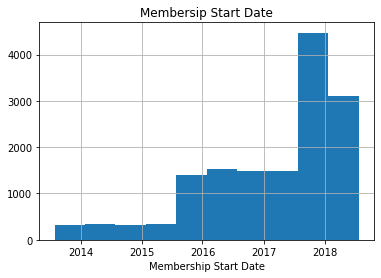

<Figure size 432x288 with 0 Axes>

In [152]:
display_customer_profile()

### Observations:

 There is a third gender O, with very few records.
 Age has quite a normal distribution , most are from 50 to 70 .
 Income is wide distribution mainly from 30,000 to 100,000.
 Memberships are mostly from 2016 and more so after 2017.

In [153]:
# explore transcript
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [154]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [155]:
# select one user and explore the transcript records
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

person            event  \
0       78afa995795e4d85b5d9ceeca43f5fef   offer received   
15561   78afa995795e4d85b5d9ceeca43f5fef     offer viewed   
47582   78afa995795e4d85b5d9ceeca43f5fef      transaction   
47583   78afa995795e4d85b5d9ceeca43f5fef  offer completed   
49502   78afa995795e4d85b5d9ceeca43f5fef      transaction   
53176   78afa995795e4d85b5d9ceeca43f5fef   offer received   
85291   78afa995795e4d85b5d9ceeca43f5fef     offer viewed   
87134   78afa995795e4d85b5d9ceeca43f5fef      transaction   
92104   78afa995795e4d85b5d9ceeca43f5fef      transaction   
141566  78afa995795e4d85b5d9ceeca43f5fef      transaction   
150598  78afa995795e4d85b5d9ceeca43f5fef   offer received   
163375  78afa995795e4d85b5d9ceeca43f5fef     offer viewed   
201572  78afa995795e4d85b5d9ceeca43f5fef   offer received   
218393  78afa995795e4d85b5d9ceeca43f5fef      transaction   
218394  78afa995795e4d85b5d9ceeca43f5fef  offer completed   
218395  78afa995795e4d85b5d9ceeca43f5fef  offer completed   
230412  78afa995795e4d85b5d9ceeca43f5fef      transaction   
262138  78afa995795e4d85b5d9ceeca43f5fef     offer viewed   

                                                    value  time  
0        {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
15561    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     6  
47582                                   {'amount': 19.89}   132  
47583   {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...   132  
49502                                   {'amount': 17.78}   144  
53176    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}   168  
85291    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}   216  
87134                                   {'amount': 19.67}   222  
92104                                   {'amount': 29.72}   240  
141566                                  {'amount': 23.93}   378  
150598   {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}   408  
163375   {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}   408  
201572   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   504  
218393                                  {'amount': 21.72}   510  
218394  {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...   510  
218395  {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...   510  
230412                                  {'amount': 26.56}   534  
262138   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   582

### Observations

Value can be offer_id, reward or transaction amount. We can create columns for these.
We are only interested in studying the data that has offer completed after it was viewed. That is the only time user actively  participated in an offer.

In [156]:
transcript.shape

(306534, 4)

In [157]:
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # Get offer_id , reward and transaction amount in columns
    for k in ['reward', 'amount']:
        transcript[k] = transcript['value'].apply(lambda x: x[k] if k in x else None)
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
    transcript.drop('value', 1, inplace=True)

    return transcript
    


In [158]:
offer = clean_transcript(transcript)

In [159]:
offer.head()

person           event  time  reward  amount  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0     NaN     NaN   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0     NaN     NaN   
2  e2127556f4f64592b11af22de27a7932  offer received     0     NaN     NaN   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0     NaN     NaN   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0     NaN     NaN   

                           offer_id  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7  
2  2906b810c7d4411798c6938adc9daaa5  
3  fafdcd668e3743c1bb461111dcafc2a4  
4  4d5c57ea9a6940dd891ad53e9dbe8da0

In [160]:
# select one user and explore the transcript records
offer[offer['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

person            event  time  reward  \
0       78afa995795e4d85b5d9ceeca43f5fef   offer received     0     NaN   
15561   78afa995795e4d85b5d9ceeca43f5fef     offer viewed     6     NaN   
47582   78afa995795e4d85b5d9ceeca43f5fef      transaction   132     NaN   
47583   78afa995795e4d85b5d9ceeca43f5fef  offer completed   132     5.0   
49502   78afa995795e4d85b5d9ceeca43f5fef      transaction   144     NaN   
53176   78afa995795e4d85b5d9ceeca43f5fef   offer received   168     NaN   
85291   78afa995795e4d85b5d9ceeca43f5fef     offer viewed   216     NaN   
87134   78afa995795e4d85b5d9ceeca43f5fef      transaction   222     NaN   
92104   78afa995795e4d85b5d9ceeca43f5fef      transaction   240     NaN   
141566  78afa995795e4d85b5d9ceeca43f5fef      transaction   378     NaN   
150598  78afa995795e4d85b5d9ceeca43f5fef   offer received   408     NaN   
163375  78afa995795e4d85b5d9ceeca43f5fef     offer viewed   408     NaN   
201572  78afa995795e4d85b5d9ceeca43f5fef   offer received   504     NaN   
218393  78afa995795e4d85b5d9ceeca43f5fef      transaction   510     NaN   
218394  78afa995795e4d85b5d9ceeca43f5fef  offer completed   510    10.0   
218395  78afa995795e4d85b5d9ceeca43f5fef  offer completed   510     5.0   
230412  78afa995795e4d85b5d9ceeca43f5fef      transaction   534     NaN   
262138  78afa995795e4d85b5d9ceeca43f5fef     offer viewed   582     NaN   

        amount                          offer_id  
0          NaN  9b98b8c7a33c4b65b9aebfe6a799e6d9  
15561      NaN  9b98b8c7a33c4b65b9aebfe6a799e6d9  
47582    19.89                              None  
47583      NaN  9b98b8c7a33c4b65b9aebfe6a799e6d9  
49502    17.78                              None  
53176      NaN  5a8bc65990b245e5a138643cd4eb9837  
85291      NaN  5a8bc65990b245e5a138643cd4eb9837  
87134    19.67                              None  
92104    29.72                              None  
141566   23.93                              None  
150598     NaN  ae264e3637204a6fb9bb56bc8210ddfd  
163375     NaN  ae264e3637204a6fb9bb56bc8210ddfd  
201572     NaN  f19421c1d4aa40978ebb69ca19b0e20d  
218393   21.72                              None  
218394     NaN  ae264e3637204a6fb9bb56bc8210ddfd  
218395     NaN  f19421c1d4aa40978ebb69ca19b0e20d  
230412   26.56                              None  
262138     NaN  f19421c1d4aa40978ebb69ca19b0e20d

In [161]:
offer.shape

(306534, 6)

In [162]:
offer.loc[offer['offer_id'] == '5a8bc65990b245e5a138643cd4eb9837'].sort_values('person').head()

person           event  time  reward  \
55972   0009655768c64bdeb2e877511632db8f  offer received   168     NaN   
77705   0009655768c64bdeb2e877511632db8f    offer viewed   192     NaN   
113919  0011e0d4e6b944f998e987f904e8c1e5  offer received   336     NaN   
133370  0011e0d4e6b944f998e987f904e8c1e5    offer viewed   354     NaN   
203452  0020c2b971eb4e9188eac86d93036a77  offer received   504     NaN   

        amount                          offer_id  
55972      NaN  5a8bc65990b245e5a138643cd4eb9837  
77705      NaN  5a8bc65990b245e5a138643cd4eb9837  
113919     NaN  5a8bc65990b245e5a138643cd4eb9837  
133370     NaN  5a8bc65990b245e5a138643cd4eb9837  
203452     NaN  5a8bc65990b245e5a138643cd4eb9837

In [163]:
# select one user and explore the transcript records
offer[offer['person']=='0009655768c64bdeb2e877511632db8f'].sort_values('time')

person            event  time  reward  \
55972   0009655768c64bdeb2e877511632db8f   offer received   168     NaN   
77705   0009655768c64bdeb2e877511632db8f     offer viewed   192     NaN   
89291   0009655768c64bdeb2e877511632db8f      transaction   228     NaN   
113605  0009655768c64bdeb2e877511632db8f   offer received   336     NaN   
139992  0009655768c64bdeb2e877511632db8f     offer viewed   372     NaN   
153401  0009655768c64bdeb2e877511632db8f   offer received   408     NaN   
168412  0009655768c64bdeb2e877511632db8f      transaction   414     NaN   
168413  0009655768c64bdeb2e877511632db8f  offer completed   414     5.0   
187554  0009655768c64bdeb2e877511632db8f     offer viewed   456     NaN   
204340  0009655768c64bdeb2e877511632db8f   offer received   504     NaN   
228422  0009655768c64bdeb2e877511632db8f      transaction   528     NaN   
228423  0009655768c64bdeb2e877511632db8f  offer completed   528     2.0   
233413  0009655768c64bdeb2e877511632db8f     offer viewed   540     NaN   
237784  0009655768c64bdeb2e877511632db8f      transaction   552     NaN   
247879  0009655768c64bdeb2e877511632db8f   offer received   576     NaN   
258883  0009655768c64bdeb2e877511632db8f      transaction   576     NaN   
258884  0009655768c64bdeb2e877511632db8f  offer completed   576     2.0   
293497  0009655768c64bdeb2e877511632db8f      transaction   660     NaN   
300930  0009655768c64bdeb2e877511632db8f      transaction   690     NaN   
302205  0009655768c64bdeb2e877511632db8f      transaction   696     NaN   

        amount                          offer_id  
55972      NaN  5a8bc65990b245e5a138643cd4eb9837  
77705      NaN  5a8bc65990b245e5a138643cd4eb9837  
89291    22.16                              None  
113605     NaN  3f207df678b143eea3cee63160fa8bed  
139992     NaN  3f207df678b143eea3cee63160fa8bed  
153401     NaN  f19421c1d4aa40978ebb69ca19b0e20d  
168412    8.57                              None  
168413     NaN  f19421c1d4aa40978ebb69ca19b0e20d  
187554     NaN  f19421c1d4aa40978ebb69ca19b0e20d  
204340     NaN  fafdcd668e3743c1bb461111dcafc2a4  
228422   14.11                              None  
228423     NaN  fafdcd668e3743c1bb461111dcafc2a4  
233413     NaN  fafdcd668e3743c1bb461111dcafc2a4  
237784   13.56                              None  
247879     NaN  2906b810c7d4411798c6938adc9daaa5  
258883   10.27                              None  
258884     NaN  2906b810c7d4411798c6938adc9daaa5  
293497   12.36                              None  
300930   28.16                              None  
302205   18.41                              None

### Offers Taken
We are only interested in offers that were viewed and completed . For informational there might be viewed followed by a transaction. That is only time user was actively involved with offer.

In [164]:
def offers_completed(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    views = pd.merge(transcript.loc[transcript['event'] == 'offer received', ['person', 'offer_id', 'time']],
                 transcript.loc[transcript['event'] == 'offer viewed', ['person', 'offer_id', 'time']],
                 on=['person', 'offer_id'], how='inner', suffixes=['_received', '_viewed'])

    # We have to be sure to take the reception BEFORE the view (or when there's no view)
    views = views.loc[(views['time_viewed'] >= views['time_received']) ]

    # Then we take the NEAREST reception before the view
    # We concatenate with the "missing view" dataframe portion, since aggregation results in a drop of these records
    views = pd.concat((views.groupby(['person', 'offer_id', 'time_viewed']).agg({'time_received': 'max'}).reset_index(),
                  views.loc[views['time_viewed'].isnull()]),
                  axis=0, sort=True)
    # Same reasoning joining the info about offer completion
    comp = pd.merge(views,
                transcript.loc[transcript['event'] == 'offer completed', ['person', 'offer_id', 'time', 'reward']],
                on=['person', 'offer_id'], how='left').rename(columns={'time': 'time_completed'})

    # When the completion time is AFTER the view time, we force the value to null
    comp.loc[(comp['time_viewed'].isnull()) | (comp['time_viewed'] > comp['time_completed']), ['time_completed', 'reward']] = (np.nan, np.nan)
    comp.drop_duplicates(inplace=True)

    comp = pd.concat(
    (comp.groupby(['person', 'offer_id', 'time_completed', 'reward']).agg({'time_viewed': 'max', 'time_received': 'max'}).reset_index(),
     comp.loc[comp['time_completed'].isnull()]),
    axis=0, sort=True
    )

    # Now we join the information about the relative transaction
    journey = pd.merge(comp,
                   transcript.loc[transcript['event'] == 'transaction', ['person', 'time', 'amount']],
                   left_on=['person', 'time_completed'], right_on=['person', 'time'], how='outer').rename(columns={'time': 'time_transaction'})

    # Create a reference time - received for offer, transaction otherwise
    journey['time'] = journey['time_received']
    journey.loc[journey['time'].isnull(), 'time'] = journey['time_transaction']

    # If an offer is completed twice, we have some duplicates: we have to remove them
    journey.sort_values(['person', 'offer_id', 'time', 'time_completed'], inplace=True)
    journey = journey.drop_duplicates(['person', 'offer_id', 'time'])

    journey = journey[['person', 'offer_id', 'time', 'time_received', 'time_viewed', 'time_completed', 'time_transaction', 'amount', 'reward']]


    return journey

In [165]:
offers = offers_completed(offer)

In [166]:
offers.shape

(172242, 9)

In [167]:
offers.head()

person                          offer_id  \
24614  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
24615  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
24616  0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d   
24617  0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4   
92312  0009655768c64bdeb2e877511632db8f                               NaN   

        time  time_received  time_viewed  time_completed  time_transaction  \
24614  336.0          336.0        372.0             NaN               NaN   
24615  168.0          168.0        192.0             NaN               NaN   
24616  408.0          408.0        456.0             NaN               NaN   
24617  504.0          504.0        540.0             NaN               NaN   
92312  228.0            NaN          NaN             NaN             228.0   

       amount  reward  
24614     NaN     NaN  
24615     NaN     NaN  
24616     NaN     NaN  
24617     NaN     NaN  
92312   22.16     NaN

In [168]:
# select one user and explore the transcript records
offers[offers['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

person                          offer_id  \
11591   78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
79938   78afa995795e4d85b5d9ceeca43f5fef                               NaN   
41442   78afa995795e4d85b5d9ceeca43f5fef  5a8bc65990b245e5a138643cd4eb9837   
90985   78afa995795e4d85b5d9ceeca43f5fef                               NaN   
94115   78afa995795e4d85b5d9ceeca43f5fef                               NaN   
114555  78afa995795e4d85b5d9ceeca43f5fef                               NaN   
11592   78afa995795e4d85b5d9ceeca43f5fef  ae264e3637204a6fb9bb56bc8210ddfd   
41443   78afa995795e4d85b5d9ceeca43f5fef  f19421c1d4aa40978ebb69ca19b0e20d   
142995  78afa995795e4d85b5d9ceeca43f5fef                               NaN   

         time  time_received  time_viewed  time_completed  time_transaction  \
11591     0.0            0.0          6.0           132.0             132.0   
79938   144.0            NaN          NaN             NaN             144.0   
41442   168.0          168.0        216.0             NaN               NaN   
90985   222.0            NaN          NaN             NaN             222.0   
94115   240.0            NaN          NaN             NaN             240.0   
114555  378.0            NaN          NaN             NaN             378.0   
11592   408.0          408.0        408.0           510.0             510.0   
41443   504.0          504.0        582.0             NaN               NaN   
142995  534.0            NaN          NaN             NaN             534.0   

        amount  reward  
11591    19.89     5.0  
79938    17.78     NaN  
41442      NaN     NaN  
90985    19.67     NaN  
94115    29.72     NaN  
114555   23.93     NaN  
11592    21.72    10.0  
41443      NaN     NaN  
142995   26.56     NaN

In [174]:
def merge_data(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
   # Join offer info
    tmp = pd.merge(transcript,
               cleaned_portfolio.rename(columns={'reward': 'pot_reward', 'id': 'offer_id'}),
               on='offer_id', how='left')

    
  # Join person info
  # We will lose some records since we dropped some profiles with no informations

    df = pd.merge(tmp,
              cleaned_profile.rename(columns={'id': 'person'}),
              how='inner', on='person')

# To better visualize the journey, let's order by the offer received time / transaction time
    df.sort_values(['person', 'time', 'offer_id'], inplace=True)
    
    # For transactions we put a specific "offer type"
    df['offer_type'].fillna('transaction', inplace=True)

    return df

In [175]:
merged_data = merge_data(offers)

In [176]:
merged_data.head()

person                          offer_id   time  \
1  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837  168.0   
4  0009655768c64bdeb2e877511632db8f                               NaN  228.0   
0  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed  336.0   
2  0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d  408.0   
5  0009655768c64bdeb2e877511632db8f                               NaN  414.0   

   time_received  time_viewed  time_completed  time_transaction  amount  \
1          168.0        192.0             NaN               NaN     NaN   
4            NaN          NaN             NaN             228.0   22.16   
0          336.0        372.0             NaN               NaN     NaN   
2          408.0        456.0             NaN               NaN     NaN   
5            NaN          NaN             NaN             414.0    8.57   

   reward  pot_reward  ...  duration     offer_type  web  email  mobile  \
1     NaN         0.0  ...       3.0  informational  0.0    1.0     1.0   
4     NaN         NaN  ...       NaN    transaction  NaN    NaN     NaN   
0     NaN         0.0  ...       4.0  informational  1.0    1.0     1.0   
2     NaN         5.0  ...       5.0           bogo  1.0    1.0     1.0   
5     NaN         NaN  ...       NaN    transaction  NaN    NaN     NaN   

   social  gender   age   income   member_on  
1     1.0       M  33.0  72000.0  2017-04-21  
4     NaN       M  33.0  72000.0  2017-04-21  
0     0.0       M  33.0  72000.0  2017-04-21  
2     1.0       M  33.0  72000.0  2017-04-21  
5     NaN       M  33.0  72000.0  2017-04-21  

[5 rows x 21 columns]

In [177]:
merged_data.shape

(150435, 21)

In [178]:
# select one user and explore the transcript records
merged_data[merged_data['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

person                          offer_id  \
69988  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
69991  78afa995795e4d85b5d9ceeca43f5fef                               NaN   
69987  78afa995795e4d85b5d9ceeca43f5fef  5a8bc65990b245e5a138643cd4eb9837   
69992  78afa995795e4d85b5d9ceeca43f5fef                               NaN   
69993  78afa995795e4d85b5d9ceeca43f5fef                               NaN   
69994  78afa995795e4d85b5d9ceeca43f5fef                               NaN   
69989  78afa995795e4d85b5d9ceeca43f5fef  ae264e3637204a6fb9bb56bc8210ddfd   
69990  78afa995795e4d85b5d9ceeca43f5fef  f19421c1d4aa40978ebb69ca19b0e20d   
69995  78afa995795e4d85b5d9ceeca43f5fef                               NaN   

        time  time_received  time_viewed  time_completed  time_transaction  \
69988    0.0            0.0          6.0           132.0             132.0   
69991  144.0            NaN          NaN             NaN             144.0   
69987  168.0          168.0        216.0             NaN               NaN   
69992  222.0            NaN          NaN             NaN             222.0   
69993  240.0            NaN          NaN             NaN             240.0   
69994  378.0            NaN          NaN             NaN             378.0   
69989  408.0          408.0        408.0           510.0             510.0   
69990  504.0          504.0        582.0             NaN               NaN   
69995  534.0            NaN          NaN             NaN             534.0   

       amount  reward  pot_reward  ...  duration     offer_type  web  email  \
69988   19.89     5.0         5.0  ...       7.0           bogo  1.0    1.0   
69991   17.78     NaN         NaN  ...       NaN    transaction  NaN    NaN   
69987     NaN     NaN         0.0  ...       3.0  informational  0.0    1.0   
69992   19.67     NaN         NaN  ...       NaN    transaction  NaN    NaN   
69993   29.72     NaN         NaN  ...       NaN    transaction  NaN    NaN   
69994   23.93     NaN         NaN  ...       NaN    transaction  NaN    NaN   
69989   21.72    10.0        10.0  ...       7.0           bogo  0.0    1.0   
69990     NaN     NaN         5.0  ...       5.0           bogo  1.0    1.0   
69995   26.56     NaN         NaN  ...       NaN    transaction  NaN    NaN   

       mobile  social  gender   age    income   member_on  
69988     1.0     0.0       F  75.0  100000.0  2017-05-09  
69991     NaN     NaN       F  75.0  100000.0  2017-05-09  
69987     1.0     1.0       F  75.0  100000.0  2017-05-09  
69992     NaN     NaN       F  75.0  100000.0  2017-05-09  
69993     NaN     NaN       F  75.0  100000.0  2017-05-09  
69994     NaN     NaN       F  75.0  100000.0  2017-05-09  
69989     1.0     1.0       F  75.0  100000.0  2017-05-09  
69990     1.0     1.0       F  75.0  100000.0  2017-05-09  
69995     NaN     NaN       F  75.0  100000.0  2017-05-09  

[9 rows x 21 columns]

In [195]:
def merge_information_transaction(df):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    inf = df.loc[(df['time_viewed'].isnull() == False) | (df['time_transaction'].isnull() == False),
             ['person', 'offer_id', 'offer_type', 'time_viewed', 'time_transaction', 'amount']]
    inf['time'] = inf['time_viewed']
    inf.loc[inf['time'].isnull(), 'time'] = inf['time_transaction']
    inf.sort_values(['person', 'time', 'offer_id'], inplace=True)

    # Now we shift the info of the subsequent record
    inf['sub_offer_type'] = inf['offer_type'].shift(-1)
    inf['sub_time'] = inf['time'].shift(-1)
    inf['sub_amount'] = inf['amount'].shift(-1)
    # If the next record is relative to another customer, we put a missing
    inf.loc[inf['person'].shift(-1) != inf['person'], ['sub_offer_type', 'sub_time', 'sub_amount']] = ['', np.nan, np.nan]

    # Finally we calculate the time difference
    inf['time_diff_with_sub'] = inf['sub_time'] - inf['time_viewed']
    
    inf.loc[inf['offer_type'] == 'informational', 'info'] = 0
    inf.loc[(inf['offer_type'] == 'informational') & (inf['sub_offer_type'] == 'transaction') & (inf['time_diff_with_sub'] <= 24), 'info'] = 1

    df1 = pd.merge(df,
              inf.loc[inf['info'].isnull() == False, ['person', 'offer_id', 'time_viewed', 'info', 'sub_time', 'sub_amount']],
              how='left', on=['person', 'offer_id', 'time_viewed'])

   # Let's force time_completed equal to time_transaction for informational data
    df1.loc[df1['info'] == 1, 'time_completed'] = df1['sub_time']
    df1.loc[df1['info'] == 1, 'time_transaction'] = df1['sub_time']
    df1.loc[df1['info'] == 1, 'amount'] = df1['sub_amount']
    df1.drop('sub_time', 1, inplace=True)
    df1.drop('sub_amount', 1, inplace=True)
    
  # Now that we have offers completed for bogo, discount and informational, lets drop all others.

    df1.dropna(subset=['time_completed'], inplace=True)

    return df1

In [196]:
merge_info = merge_information_transaction(merged_data)

In [201]:
merge_info.shape

(26450, 22)

In [202]:
# select one user and explore the transcript records
merge_info[merge_info['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

person                          offer_id  \
69987  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
69989  78afa995795e4d85b5d9ceeca43f5fef  5a8bc65990b245e5a138643cd4eb9837   
69993  78afa995795e4d85b5d9ceeca43f5fef  ae264e3637204a6fb9bb56bc8210ddfd   

        time  time_received  time_viewed  time_completed  time_transaction  \
69987    0.0            0.0          6.0           132.0             132.0   
69989  168.0          168.0        216.0           222.0             222.0   
69993  408.0          408.0        408.0           510.0             510.0   

       amount  reward  pot_reward  ...     offer_type  web email  mobile  \
69987   19.89     5.0         5.0  ...           bogo  1.0   1.0     1.0   
69989   19.67     NaN         0.0  ...  informational  0.0   1.0     1.0   
69993   21.72    10.0        10.0  ...           bogo  0.0   1.0     1.0   

       social  gender   age    income   member_on  info  
69987     0.0       F  75.0  100000.0  2017-05-09   NaN  
69989     1.0       F  75.0  100000.0  2017-05-09   1.0  
69993     1.0       F  75.0  100000.0  2017-05-09   NaN  

[3 rows x 22 columns]

### Cleaned completed offers set
- Now we have a cleaned completed offers. Lets save it



In [203]:
# Write output
merge_info.to_csv('./data/cleaned_completed_offers.csv', index=False)

### Cleaned completed offers set

- Now we have a cleaned completed offers set that we can use to build our recommendation engine.
- We will build User based collaborative filtering, however that will have a Cold Start Problem
- To address cold Start problem we will come up with rank based recommendations.

In [262]:
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [263]:
# check how many times the offer has sent
offer[offer['event']=='offer received']['time'].unique()

array([  0, 168, 336, 408, 504, 576], dtype=int64)

In [264]:
# check the same user transcript records
offer[offer['person']=='0009655768c64bdeb2e877511632db8f']

event                            person  time  \
55972    offer received  0009655768c64bdeb2e877511632db8f   168   
77705      offer viewed  0009655768c64bdeb2e877511632db8f   192   
113605   offer received  0009655768c64bdeb2e877511632db8f   336   
139992     offer viewed  0009655768c64bdeb2e877511632db8f   372   
153401   offer received  0009655768c64bdeb2e877511632db8f   408   
168413  offer completed  0009655768c64bdeb2e877511632db8f   414   
187554     offer viewed  0009655768c64bdeb2e877511632db8f   456   
204340   offer received  0009655768c64bdeb2e877511632db8f   504   
228423  offer completed  0009655768c64bdeb2e877511632db8f   528   
233413     offer viewed  0009655768c64bdeb2e877511632db8f   540   
247879   offer received  0009655768c64bdeb2e877511632db8f   576   
258884  offer completed  0009655768c64bdeb2e877511632db8f   576   

                                                    value  \
55972    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}   
77705    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}   
113605   {'offer id': '3f207df678b143eea3cee63160fa8bed'}   
139992   {'offer id': '3f207df678b143eea3cee63160fa8bed'}   
153401   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   
168413  {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...   
187554   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   
204340   {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
228423  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   
233413   {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
247879   {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   
258884  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...   

                                offer_id  
55972   5a8bc65990b245e5a138643cd4eb9837  
77705   5a8bc65990b245e5a138643cd4eb9837  
113605  3f207df678b143eea3cee63160fa8bed  
139992  3f207df678b143eea3cee63160fa8bed  
153401  f19421c1d4aa40978ebb69ca19b0e20d  
168413  f19421c1d4aa40978ebb69ca19b0e20d  
187554  f19421c1d4aa40978ebb69ca19b0e20d  
204340  fafdcd668e3743c1bb461111dcafc2a4  
228423  fafdcd668e3743c1bb461111dcafc2a4  
233413  fafdcd668e3743c1bb461111dcafc2a4  
247879  2906b810c7d4411798c6938adc9daaa5  
258884  2906b810c7d4411798c6938adc9daaa5

In [265]:
offer.shape

(167581, 5)

In [298]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix


In [299]:
full_df = create_user_item_matrix(offer, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [300]:
full_df.head()

offer_id                          0b1e1539f2cc45b7b9fa7c272da2e1d7  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               1.0   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          2298d6c36e964ae4a3e7e9706d1fb8c2  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               1.0   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               1.0   

offer_id                          2906b810c7d4411798c6938adc9daaa5  \
person                                                               
0009655768c64bdeb2e877511632db8f                               0.0   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          4d5c57ea9a6940dd891ad53e9dbe8da0  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               1.0   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          9b98b8c7a33c4b65b9aebfe6a799e6d9  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               1.0   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               1.0   

offer_id                          ae264e3637204a6fb9bb56bc8210ddfd  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               0.0   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          f19421c1d4aa40978ebb69ca19b0e20d  \
person                                                               
0009655768c64bdeb2e877511632db8f                               0.0   
00116118485d4dfda04fdbaba9a87b5c                               0.0   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               1.0   

offer_id                          fafdcd668e3743c1bb461111dcafc2a4  
person                                                              
0009655768c64bdeb2e877511632db8f                               0.0  
00116118485d4dfda04fdbaba9a87b5c                               NaN  
0011e0d4e6b944f998e987f904e8c1e5                               NaN  
0020c2b971eb4e9188eac86d93036a77                               1.0  
0020ccbbb6d84e358d3414a3ff76cffd                               NaN

In [342]:
train_size = int(offer.shape[0]*0.7)
test_size = offer.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [343]:
train_offer = offer[:train_size]

In [344]:
test_offer = offer[train_size:]

In [345]:
train_df = create_user_item_matrix(train_offer, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [346]:
train_df.head()

offer_id                          0b1e1539f2cc45b7b9fa7c272da2e1d7  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               0.0   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          2298d6c36e964ae4a3e7e9706d1fb8c2  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               1.0   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               1.0   

offer_id                          2906b810c7d4411798c6938adc9daaa5  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          4d5c57ea9a6940dd891ad53e9dbe8da0  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               0.0   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          9b98b8c7a33c4b65b9aebfe6a799e6d9  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               0.0   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               0.0   

offer_id                          ae264e3637204a6fb9bb56bc8210ddfd  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               0.0   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          f19421c1d4aa40978ebb69ca19b0e20d  \
person                                                               
0009655768c64bdeb2e877511632db8f                               0.0   
00116118485d4dfda04fdbaba9a87b5c                               0.0   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               1.0   

offer_id                          fafdcd668e3743c1bb461111dcafc2a4  
person                                                              
0009655768c64bdeb2e877511632db8f                               0.0  
00116118485d4dfda04fdbaba9a87b5c                               NaN  
0011e0d4e6b944f998e987f904e8c1e5                               NaN  
0020c2b971eb4e9188eac86d93036a77                               1.0  
0020ccbbb6d84e358d3414a3ff76cffd                               NaN

In [347]:
test_df = create_user_item_matrix(test_offer, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128

In [348]:
test_df.head()

offer_id                          0b1e1539f2cc45b7b9fa7c272da2e1d7  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               0.0   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          2298d6c36e964ae4a3e7e9706d1fb8c2  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          2906b810c7d4411798c6938adc9daaa5  \
person                                                               
0009655768c64bdeb2e877511632db8f                               0.0   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          4d5c57ea9a6940dd891ad53e9dbe8da0  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               0.0   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          9b98b8c7a33c4b65b9aebfe6a799e6d9  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               0.0   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               0.0   

offer_id                          ae264e3637204a6fb9bb56bc8210ddfd  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               NaN   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          f19421c1d4aa40978ebb69ca19b0e20d  \
person                                                               
0009655768c64bdeb2e877511632db8f                               NaN   
00116118485d4dfda04fdbaba9a87b5c                               0.0   
0011e0d4e6b944f998e987f904e8c1e5                               NaN   
0020c2b971eb4e9188eac86d93036a77                               NaN   
0020ccbbb6d84e358d3414a3ff76cffd                               NaN   

offer_id                          fafdcd668e3743c1bb461111dcafc2a4  
person                                                              
0009655768c64bdeb2e877511632db8f                               0.0  
00116118485d4dfda04fdbaba9a87b5c                               NaN  
0011e0d4e6b944f998e987f904e8c1e5                               NaN  
0020c2b971eb4e9188eac86d93036a77                               0.0  
0020ccbbb6d84e358d3414a3ff76cffd                               NaN

In [9]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat 


In [52]:
# Run this cell if you want to omit the long process of matrix creation
# full_df = pd.read_pickle('user_item_matrix.p')

In [17]:
# Run this cell if you want to omit the long process of matrix creation
# train_df = pd.read_pickle('train_df.p')

In [18]:
# Run this cell if you want to omit the long process of matrix creation
# test_df = pd.read_pickle('train_df.p')

In [11]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.320741
2 		 0.267338
3 		 0.266980
4 		 0.266610
5 		 0.266234
6 		 0.265853
7 		 0.265466
8 		 0.265074
9 		 0.264674
10 		 0.264268
11 		 0.263855
12 		 0.263433
13 		 0.263003
14 		 0.262564
15 		 0.262115
16 		 0.261656
17 		 0.261185
18 		 0.260702
19 		 0.260206
20 		 0.259697
21 		 0.259172
22 		 0.258632
23 		 0.258075
24 		 0.257500
25 		 0.256905
26 		 0.256290
27 		 0.255652
28 		 0.254992
29 		 0.254306
30 		 0.253593
31 		 0.252853
32 		 0.252082
33 		 0.251279
34 		 0.250442
35 		 0.249570
36 		 0.248659
37 		 0.247708
38 		 0.246715
39 		 0.245677
40 		 0.244592
41 		 0.243458
42 		 0.242271
43 		 0.241031
44 		 0.239734
45 		 0.238377
46 		 0.236960
47 		 0.235478
48 		 0.233931
49 		 0.232315
50 		 0.230630
51 		 0.228873
52 		 0.227042
53 		 0.225136
54 		 0.223155
55 		 0.221097
56 		 0.218962
57 		 0.216749
58 		 0.214459
59 		 0.212093
60 		 0.209651
61 		 0.207136
62 		 0.204548
63 		 0.201890
64 		 0

In [12]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.293689
2 		 0.266818
3 		 0.266351
4 		 0.265873
5 		 0.265393
6 		 0.264909
7 		 0.264422
8 		 0.263932
9 		 0.263437
10 		 0.262939
11 		 0.262435
12 		 0.261927
13 		 0.261414
14 		 0.260895
15 		 0.260370
16 		 0.259839
17 		 0.259300
18 		 0.258755
19 		 0.258201
20 		 0.257639
21 		 0.257067
22 		 0.256486
23 		 0.255894
24 		 0.255291
25 		 0.254675
26 		 0.254047
27 		 0.253405
28 		 0.252748
29 		 0.252076
30 		 0.251386
31 		 0.250679
32 		 0.249952
33 		 0.249205
34 		 0.248436
35 		 0.247644
36 		 0.246828
37 		 0.245985
38 		 0.245116
39 		 0.244217
40 		 0.243287
41 		 0.242325
42 		 0.241329
43 		 0.240297
44 		 0.239227
45 		 0.238118
46 		 0.236967
47 		 0.235774
48 		 0.234535
49 		 0.233250
50 		 0.231917
51 		 0.230534
52 		 0.229099
53 		 0.227612
54 		 0.226070
55 		 0.224473
56 		 0.222820
57 		 0.221109
58 		 0.219341
59 		 0.217514
60 		 0.215629
61 		 0.213685
62 		 0.211684
63 		 0.209625
64 		 0

In [13]:
# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.279275
2 		 0.267474
3 		 0.266634
4 		 0.265789
5 		 0.264945
6 		 0.264100
7 		 0.263254
8 		 0.262409
9 		 0.261563
10 		 0.260716
11 		 0.259870
12 		 0.259023
13 		 0.258176
14 		 0.257328
15 		 0.256480
16 		 0.255632
17 		 0.254783
18 		 0.253934
19 		 0.253084
20 		 0.252234
21 		 0.251383
22 		 0.250531
23 		 0.249678
24 		 0.248824
25 		 0.247969
26 		 0.247114
27 		 0.246256
28 		 0.245398
29 		 0.244538
30 		 0.243676
31 		 0.242813
32 		 0.241947
33 		 0.241080
34 		 0.240210
35 		 0.239337
36 		 0.238462
37 		 0.237584
38 		 0.236703
39 		 0.235818
40 		 0.234930
41 		 0.234037
42 		 0.233141
43 		 0.232240
44 		 0.231334
45 		 0.230423
46 		 0.229507
47 		 0.228585
48 		 0.227657
49 		 0.226722
50 		 0.225781
51 		 0.224833
52 		 0.223877
53 		 0.222913
54 		 0.221940
55 		 0.220959
56 		 0.219969
57 		 0.218970
58 		 0.217960
59 		 0.216941
60 		 0.215910
61 		 0.214869
62 		 0.213816
63 		 0.212751
64 		 0

In [20]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("I'm sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
    
        return None


In [15]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)


In [384]:
# Evaluation for latent features of 15
validation(test_df, user_mat, offer_mat)

0.33037353189698154


In [21]:
# Evaluation for latent features of 10
validation(test_df, user_mat_10, offer_mat_10)

0.00917476430491666


In [22]:
# Evaluation for latent features of 5
validation(test_df, user_mat_5, offer_mat_5)

0.023911395735760205


In [54]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))
        


In [55]:
# recommend offer for a particular user
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  1.3
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.99
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.73
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.54
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.28
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.24
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.09
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.06


Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


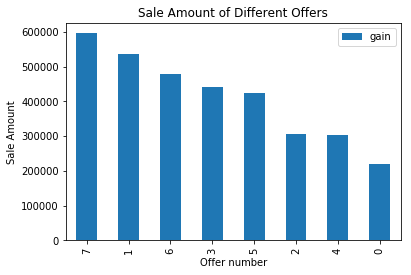

In [58]:
# we recommend top best sale offer to a new user
recommend_offer('new_user', user_mat, offer_mat)

In [308]:
def gender_offer(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # We count the number of offer completed base on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers responsed our offers.
            gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")


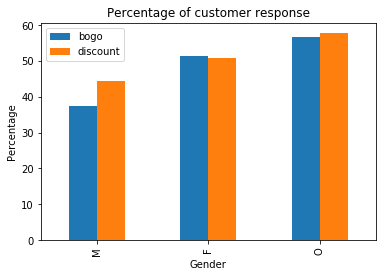

In [309]:
gender_offer(full_df)

In [317]:
cleaned_portfolio

difficulty  duration                                id  reward  web  email  \
0          10       168  ae264e3637204a6fb9bb56bc8210ddfd      10    0      1   
1          10       120  4d5c57ea9a6940dd891ad53e9dbe8da0      10    1      1   
2           0        96  3f207df678b143eea3cee63160fa8bed       0    1      1   
3           5       168  9b98b8c7a33c4b65b9aebfe6a799e6d9       5    1      1   
4          20       240  0b1e1539f2cc45b7b9fa7c272da2e1d7       5    1      1   
5           7       168  2298d6c36e964ae4a3e7e9706d1fb8c2       3    1      1   
6          10       240  fafdcd668e3743c1bb461111dcafc2a4       2    1      1   
7           0        72  5a8bc65990b245e5a138643cd4eb9837       0    0      1   
8           5       120  f19421c1d4aa40978ebb69ca19b0e20d       5    1      1   
9          10       168  2906b810c7d4411798c6938adc9daaa5       2    1      1   

   mobile  social  bogo  discount  informational  
0       1       1     1         0              0  
1       1       1     1         0              0  
2       1       0     0         0              1  
3       1       0     1         0              0  
4       0       0     0         1              0  
5       1       1     0         1              0  
6       1       1     0         1              0  
7       1       1     0         0              1  
8       1       1     1         0              0  
9       1       0     0         1              0

In [336]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")


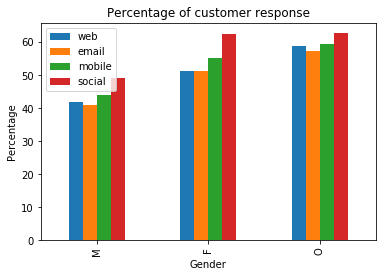

In [337]:
gender_offer_channel(full_df)

In [49]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94

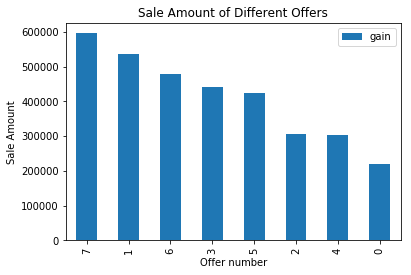

In [53]:
best_sale_offer(full_df)